# Econometrics for the Biological Sciences

## Fundamental Concepts

- Regression
  - Study of conditional distributions
- Level I, II, and III analysis
- Models vs. Algorithms
- Estimation vs. Inference
  - Inference: Goal is to use a sample to say something about the population.
- Econometrics vs. Statistical Learning vs. ML
- Experimental vs. Quasi-Experimental vs. Observational
- Degrees of Freedom
- Counterfactual
- Average Treatment Effect
- Average Treatment on the Treated
- Bias
- Power
- Sampling Distribution
- Null Hypothesis $H_0$
- Alternative Hypothesis $H_A$
- Sufficient Statistic

### Objectives

1. Identification
2. Unbiased estimate of the treatment effect
3. Valid standard errors for the treatment effect
4. Explanation

### General Assumptions

- Make a credible case for a causal relationship, i.e. there is a model in play
- Gauss-Markov Theorem
- Neyman-Rubin Causal Model

### Some Problems

Small effect sizes + Noisy Measurements + RCT = Difficult Estimation Task

Small effect sizes + Noisy Measurements - RCT = **Extremely** Difficult Estimation Task

**Experimental Flaws**
- Spill over effects
- Insufficient Randomization
- **Attrition**
- **Partial Compliance**

Existence of experimental flaws requires that additional methods be applied on top of traditional methods. Usually thought of as techniques for handling quasi-experimental data

**Data Analysis/Modelling Problems**
- Model misspecification error
- Omitted variable bias (Confounding)
- Selection bias
  - Population studied may not be representative of the population of interest (returns to college education)
  - Not the same joint probability distribution
- Endogeneity Bias (Simultenaity)
  - Non-random treatment assignment
- Measurement Error
- Data Snooping/Model Selection

## Running Example: Estimating the Effect of Free Breakfast on Academic Achievement

- Students are the primary observation unit
- Free breakfast was provided to some students but not others
- Outcome of interest are scores on a standardized test

## Core Techniques

- Multiple Regression
- Difference-in-Difference
  - Estimate a treatment effect when baseline data is available prior to treatment
- Fixed Effects
- Matching
  - Overcome non-random treatment assignment
- Instrumental Variables
  - Overcome omitted variable bias and endogeneity bias
- Regression Discontinuity
  - Exploits thresholds (and entities just on either sides of them)

## Other Techniques
- Multi-level modelling
- Synthetic Controls
  - Use weighting to get a better control group

## Machine Learning for Causal Inference

- BART
- SuperLearner
- Causal Trees/Forests
- DoubleML

## Differential Treatment Effects
- Fixed Effects models (fixed effect for each entity)
- Hierarchical model where treatment effects come from a common distribution
- Add interaction terms
- ML for CI

## Case Study: Estimating Heterogeneous Treatment Effects

## Resources

### Books
- [Statistical Learning from a Regression Perspective]
- [Data Analysis Using Regression and Multilevel/Hierarchical Models]
- [Mostly Harmless Econometrics]
- [Introduction to Statistical Learning]
- [Elements of Statistical Learning]
- [Introductory Econometrics: A Modern Approach]
- [Econometric Analysis of Cross Section and Panel Data]
- [Introduction to Econometrics]

### Papers

### Blogs
- [Causal Forest Intro](https://www.markhw.com/blog/causalforestintro)

### Software
- [Personalized]
- [FindIt]
- [uplift]
- [BART]
- [grf]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from scipy.stats import ttest_1samp

sns.set_style("darkgrid")

## Back to Basics

Text(0.5, 1.0, "Student's t and Normal Distribution")

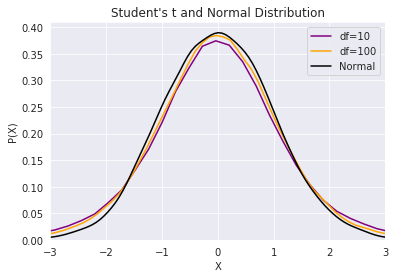

In [75]:
t_dist_5 = np.random.standard_t(df=5, size=100000)
t_dist_10 = np.random.standard_t(df=10, size=100000)
normal = np.random.standard_normal(size=10000)

fig, ax = plt.subplots()
sns.distplot(t_dist_5, hist=False, rug=False, ax=ax, label="df=10", color="purple")
sns.distplot(t_dist_10, hist=False, rug=False, ax=ax, label="df=100", color="orange")
sns.distplot(normal, hist=False, rug=False, ax=ax, label="Normal", color="black")
ax.set_xlim(-3, 3)
ax.set_xlabel("X")
ax.set_ylabel("P(X)")
ax.set_title("Student's t and Normal Distribution")

- As $n \rightarrow \infty$, $T \approx N$
- Student's t distribution does not depend on $\mu$ or $\sigma^2$, which are the unknown parameters of interest if our population being sampled is normally distributed
- Can be used for establishing confidence intervals for the population mean

Text(75, 0.001, 'True Mean')

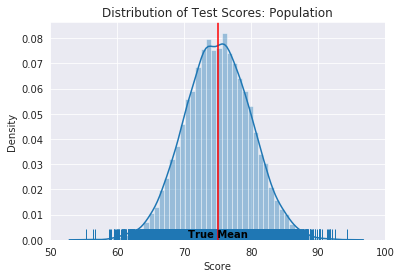

In [6]:
natures_students = np.random.normal(loc=75, scale=5, size=10000)\

fig, ax = plt.subplots()
sns.distplot(natures_students, rug=True, norm_hist=True, ax=ax)
ax.axvline(75, 0, 1, color="r")
ax.set_title("Distribution of Test Scores: Population")
ax.set_xlabel("Score")
ax.set_xlim(50, 100)
ax.set_ylabel("Density")
ax.text(75, 0.001, "True Mean", horizontalalignment='center', size='medium', color='black', weight='semibold')

Text(0, 0.5, 'Density')

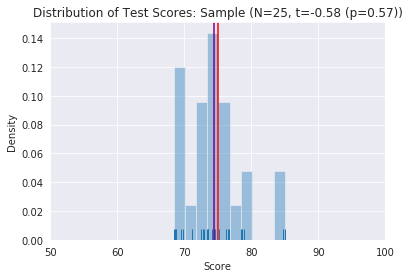

In [91]:
sample_students = np.random.normal(loc=75, scale=5, size=25)

t, p_val = ttest_1samp(sample_students, 75)

fig, ax = plt.subplots()
sns.distplot(sample_students, bins=10, kde=False, rug=True, norm_hist=True, ax=ax)
ax.axvline(75, 0, 1, color="r")
ax.axvline(np.mean(sample_students), 0, 1, color="purple")
ax.set_xlim(50, 100)
ax.set_title("Distribution of Test Scores: Sample (N=25, t={} (p={}))".format(round(t, 2), round(p_val, 2)))
ax.set_xlabel("Score")
ax.set_ylabel("Density")

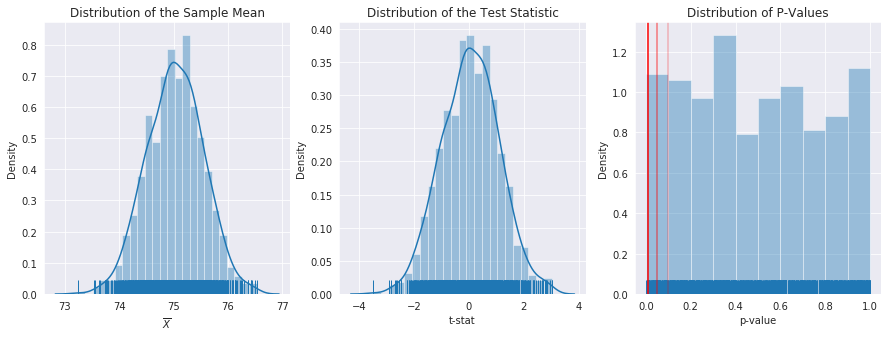

In [107]:
repeated_samples = np.random.normal(loc=75, scale=5, size=(100, 1000))
sample_means = np.mean(repeated_samples, axis=0)
t_stats, p_vals = ttest_1samp(repeated_samples, 75)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

sns.distplot(sample_means, kde=True, rug=True, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribution of the Sample Mean")
ax[0].set_xlabel("$\overline{X}$")
ax[0].set_ylabel("Density")

sns.distplot(t_stats, kde=True, rug=True, norm_hist=True, ax=ax[1])
ax[1].set_title("Distribution of the Test Statistic")
ax[1].set_xlabel("t-stat")
ax[1].set_ylabel("Density")

sns.distplot(p_vals, kde=False, rug=True, norm_hist=True, ax=ax[2])
ax[2].set_title("Distribution of P-Values")
ax[2].set_xlabel("p-value")
ax[2].set_ylabel("Density")
ax[2].axvline(0.01, 0, 1, color="r", alpha=1.0)
ax[2].axvline(0.05, 0, 1, color="r", alpha=0.5)
ax[2].axvline(0.10, 0, 1, color="r", alpha=0.25)

## OLS

The following thought experiment underlies the standard linear regression model:
1. For each case $i$, Mother Nature establishes the values of each of the predictors
2. Mother Nature then multiplies each predictor by its corresponding coefficient
3. Mother Nature sums the products from (2) and adds the value of the constant
4. Mother Nature then adds a random perturbation

The goal of the data analyst is to back-out the coefficients that Mother Nature used to generate the data. OLS is the the estimator used to accomplish the task.

First Order Conditions

- The predictors used by Mother Nature are known
- The transformations used by Mother Nature are known
- The predictors are known to be combined in a linear fashion
- The predictors are available in the data

Second Order Conditions

- Each perturbation is realized idepedently of all other perturbations and all come from the same distribution with expectation 0 $$\epsilon_i \sim NIID(0, \sigma^2)$$

Distributions of the estimated coefficients is approximately normal when the sample size is large. How large is large though?